We start importing the required libraries. 

In [1]:
# Import required libraries
import matplotlib.pyplot as plt
import numpy as np

import dolfinx.fem as fem
import dolfinx.mesh as mesh
import dolfinx.io as io
import dolfinx.plot as plot
import ufl
import basix 

from mpi4py import MPI
from petsc4py import PETSc
from petsc4py.PETSc import ScalarType
import sys
sys.path.append("python")
from meshes import generate_mesh_with_crack
from petsc_solvers import SNESSolver

petsc_options_SNES = {
    "snes_type": "vinewtonrsls",
    "snes_linesearch_type": "basic",
    "ksp_type": "preonly",
    "pc_type": "lu",
    "pc_factor_mat_solver_type": "mumps",
    "snes_atol": 1.0e-08,
    "snes_rtol": 1.0e-09,
    "snes_stol": 0.0,
    "snes_max_it": 50,
    "snes_monitor": "",
    # "snes_monitor_cancel": "",
}

petsc_options_SNESQN = {
    "snes_type": "qn",
    "snes_qn_type": "lbfgs", #lbfgs broyden, badbroyden
    "snes_qn_m": 100,
    "snes_qn_scale_type": "jacobian", #<diagonal,none,scalar,jacobian> 	
    "snes_qn_restart_type": "none", #<powell,periodic,none> 
    "pc_type": "cholesky", # cholesky >> hypre > gamg,sor ; asm, lu, gas - don't work
    "snes_linesearch_type": "basic",
    "ksp_type": "preonly",
    "pc_factor_mat_solver_type": "mumps",
    "snes_atol": 1.0e-08,
    "snes_rtol": 1.0e-08,
    "snes_stol": 0.0,
    "snes_max_it": 50,
    # "snes_monitor": "",
    "snes_monitor_cancel": "",
}

def interpolate_quadrature(expr, funct, degree):
    quadrature_points, wts = basix.make_quadrature(basix.CellType.triangle, degree)
    mesh = u.function_space.mesh
    map_c = mesh.topology.index_map(mesh.topology.dim)
    num_cells = map_c.size_local + map_c.num_ghosts
    cells = np.arange(0, num_cells, dtype=np.int32)

    expr_expr = fem.Expression(expr, quadrature_points)
    expr_eval = expr_expr.eval(cells)

    with funct.vector.localForm() as funct_local:
        funct_local.setBlockSize(funct.function_space.dofmap.bs)
        funct_local.setValuesBlocked(
            funct.function_space.dofmap.list.array,
            expr_eval,
            addv=PETSc.InsertMode.INSERT,
        )
        
def interpolate_quadrature(ufl_expr, fem_func:fem.Function):
    q_dim = fem_func.function_space._ufl_element.degree()
    mesh = fem_func.ufl_function_space().mesh
    
    basix_celltype = getattr(basix.CellType, mesh.topology.cell_type.name)
    quadrature_points, weights = basix.make_quadrature(basix_celltype, q_dim)
    map_c = mesh.topology.index_map(mesh.topology.dim)
    num_cells = map_c.size_local + map_c.num_ghosts
    cells = np.arange(0, num_cells, dtype=np.int32)

    expr_expr = fem.Expression(ufl_expr, quadrature_points)
    expr_eval = expr_expr.eval(cells)
    fem_func.x.array[:] = expr_eval.flatten()[:]
    # fem_func.x.scatter_forward()

# Defining the function to interpolate a function defined over quadrature elements
# def interpolate_quadrature(ufl_expr, q_dim, mesh):
#     basix_celltype = getattr(basix.CellType, mesh.topology.cell_type.name)
#     quadrature_points, weights = basix.make_quadrature(basix_celltype, q_dim)
#     map_c = mesh.topology.index_map(mesh.topology.dim)
#     num_cells = map_c.size_local + map_c.num_ghosts
#     cells = np.arange(0, num_cells, dtype=np.int32)

#     expr_expr = fem.Expression(ufl_expr, quadrature_points)
#     expr_eval = expr_expr.eval(cells)
#     return expr_eval

# Interpolate an expression on an element
def interpolate_quadrature_on_element(expr, function_space:fem.FunctionSpace, mesh, cell_number):
    assert function_space.family() == 'Quadrature'
    
    q_dim = function_space.degree()
    
    basix_celltype = getattr(basix.CellType, mesh.topology.cell_type.name)
    quadrature_points, _ = basix.make_quadrature(basix_celltype, q_dim)

    expr_expr = fem.Expression(expr, quadrature_points)
    expr_eval = expr_expr.eval(cell_number)
    return expr_eval


In [2]:
Lx = 1.
Ly = .5
Lcrack = 0.3
lc =.2
dist_min = .1
dist_max = .3
msh, mt, ft = generate_mesh_with_crack(
        Lcrack=Lcrack,
        Ly=Ly,
        lc=0.1,  # caracteristic length of the mesh
        refinement_ratio=10,  # how much it is refined at the tip zone
        dist_min=dist_min,  # radius of tip zone
        dist_max=dist_max,  # radius of the transition zone
    )

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 40%] Meshing curve 3 (Line)
Info    : [ 60%] Meshing curve 4 (Line)
Info    : [ 80%] Meshing curve 5 (Line)
Info    : Done meshing 1D (Wall 0.00229683s, CPU 0.002469s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.00642742s, CPU 0.006327s)
Info    : 413 nodes 829 elements


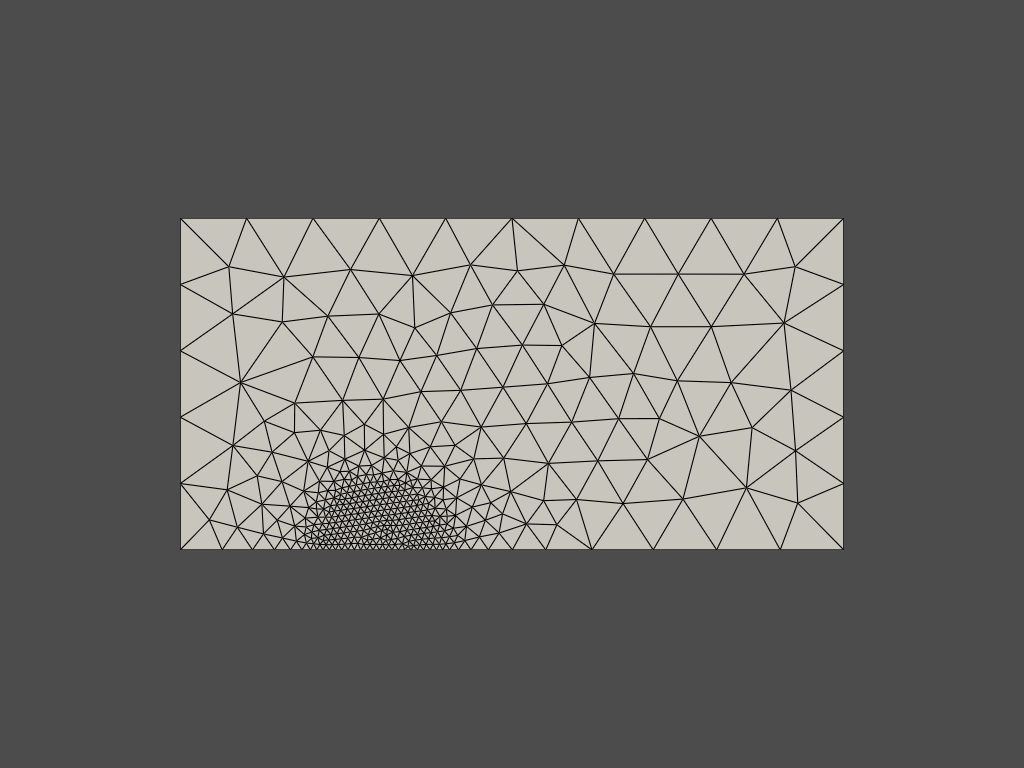

In [3]:
import pyvista
pyvista.set_jupyter_backend("none")
grid = pyvista.UnstructuredGrid(*plot.create_vtk_mesh(msh))
plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.camera_position = 'xy'
pyvista.OFF_SCREEN = False
if not pyvista.OFF_SCREEN:
    plotter.show()

## Finite element function space

We use here linear Lagrange triangle elements

In [4]:

deg_stress = 0
deg_u = 1

element = ufl.FiniteElement('Lagrange',msh.ufl_cell(),degree=deg_u)
V = fem.FunctionSpace(msh, element)

element_stress = ufl.VectorElement("DG", msh.ufl_cell(), degree=deg_stress, quad_scheme='default')
element_stress_scalar = ufl.FiniteElement("DG", msh.ufl_cell(), degree=deg_stress, quad_scheme='default')

V_stress = fem.FunctionSpace(msh, element_stress)
V_stress_scalar = fem.FunctionSpace(msh, element_stress_scalar)


In [5]:
def bottom_no_crack(x):
    return np.logical_and(np.isclose(x[1], 0.0), 
                          x[0] > Lcrack)
    
def left(x):
    return np.isclose(x[0], 0)

def top(x):
    return np.isclose(x[1], Ly)

bottom_no_crack_facets = mesh.locate_entities_boundary(msh, msh.topology.dim-1, bottom_no_crack)
bottom_no_crack_dofs_y = fem.locate_dofs_topological(V, msh.topology.dim-1, bottom_no_crack_facets)

top_facets = mesh.locate_entities_boundary(msh, msh.topology.dim-1, top)
top_dofs = fem.locate_dofs_topological(V, msh.topology.dim-1, top_facets)

left_facets = mesh.locate_entities_boundary(msh, msh.topology.dim-1, left)
left_dofs = fem.locate_dofs_topological(V, msh.topology.dim-1, left_facets)

u_t = fem.Constant(msh,1.)
bc_bottom = fem.dirichletbc(np.array(0.,dtype=ScalarType), bottom_no_crack_dofs_y, V)
bc_left = fem.dirichletbc(u_t, left_dofs, V)
bcs = [bc_bottom, bc_left]

dx = ufl.Measure("dx",domain=msh,  metadata={"quadrature_degree": deg_stress, "quadrature_scheme": "default"} )
top_facets = mesh.locate_entities_boundary(msh, 1, lambda x : np.isclose(x[1], Ly))
mt = mesh.meshtags(msh, 1, top_facets, 1)
ds = ufl.Measure("ds", subdomain_data=mt)

$$
\mathcal{E}(u,d\varepsilon_p)=\int_\Omega \frac{\mu}{2} (\nabla u-\varepsilon_{p_{old}}-\Delta\varepsilon_p) \cdot (\nabla u-\varepsilon_{p_{old}}-\Delta\varepsilon_p)
+ \sigma_p (p_{old}+\Vert \Delta\varepsilon_p\Vert)
$$

$$
\sigma =  \mu (\nabla u-\varepsilon_{p_{old}}-\Delta\varepsilon_p),\quad \sigma_{elas}=\mu (\nabla u-\varepsilon_{p_{old}})
$$

Either 
$\Delta\varepsilon_p=0$ or the derivative with respect to $ \Delta\varepsilon_p$ gives
$$
\left(-\sigma_{elas}+\mu\, \Vert \Delta\varepsilon_p\Vert \frac{ \Delta\varepsilon_p}{\Vert \Delta\varepsilon_p\Vert}+\sigma_p \frac{ \Delta\varepsilon_p}{\Vert \Delta\varepsilon_p\Vert}\right)
\cdot
\hat{\Delta\varepsilon_p}=0
$$
For $\hat{\Delta\varepsilon_p}=\Delta\varepsilon_p$:
$$
\frac{\Delta\varepsilon_p}{\Vert \Delta\varepsilon_p\Vert}
=
\frac{\sigma_{elas}}{\Vert\sigma_{elas}\Vert}$$
$$
\Vert \Delta\varepsilon_p\Vert=\frac{\Vert\sigma_{elas}\Vert-\sigma_p}{\mu}
$$

$$
\Delta\varepsilon_p=
\frac{\Vert\sigma_{elas}\Vert-\sigma_p}{\mu}
\frac{\sigma_{elas}}{\Vert\sigma_{elas}\Vert}
$$

In [6]:

mu = fem.Constant(msh,PETSc.ScalarType(1.))

def eps(u):
    """Strain"""
    return ufl.grad(u)

def L(v): 
    """The linear form of the weak formulation"""
    # Volume force
    b = fem.Constant(msh,ScalarType(0))

    # Surface force on the top
    f = fem.Constant(msh,ScalarType(0.))
    return b * v * dx + f * v * ds(1)

def deps_p(sigma_elas,mu,sig_0) : 
    sigma_elas_norm = ufl.sqrt(ufl.inner(sigma_elas, sigma_elas))
    direction = sigma_elas / sigma_elas_norm
    criterion = sigma_elas_norm - sig_0 # - H*old_p
    #lambda_ = ufl.conditional(criterion > fem.Constant(msh,PETSc.ScalarType(0.)), criterion / mu, fem.Constant(msh,PETSc.ScalarType(0.))) # sig_eq is equal to 0 on the first iteration
    # dp = ppos(f_elas)/(3*mu+H) # this approach doesn't work with ufl.derivate
    #return  lambda_ * direction
    return  ufl.conditional(criterion > 0, - (criterion / mu) * direction , ufl.as_vector([0,0]))

Solve for t=0.0
  0 SNES Function norm 0.000000000000e+00 
(0, 2)
Solve for t=0.02040816326530612
  0 SNES Function norm 7.560120419786e-02 
  1 SNES Function norm 8.824653992184e-17 
(1, 2)
Solve for t=0.04081632653061224
  0 SNES Function norm 7.560120419786e-02 
  1 SNES Function norm 1.125280610232e-16 
(1, 2)
Solve for t=0.061224489795918366
  0 SNES Function norm 7.560120419786e-02 
  1 SNES Function norm 1.267791084123e-16 
(1, 2)
Solve for t=0.08163265306122448
  0 SNES Function norm 7.560120419786e-02 
  1 SNES Function norm 6.572277087051e-04 
  2 SNES Function norm 2.788341088098e-06 
  3 SNES Function norm 4.392134915108e-11 
(3, 2)
Solve for t=0.1020408163265306
  0 SNES Function norm 7.560766871763e-02 
  1 SNES Function norm 3.053922114157e-04 
  2 SNES Function norm 2.631442670466e-07 
  3 SNES Function norm 2.190833547686e-13 
(3, 2)
Solve for t=0.12244897959183673
  0 SNES Function norm 7.567165052446e-02 
  1 SNES Function norm 7.468605600375e-04 
  2 SNES Function n

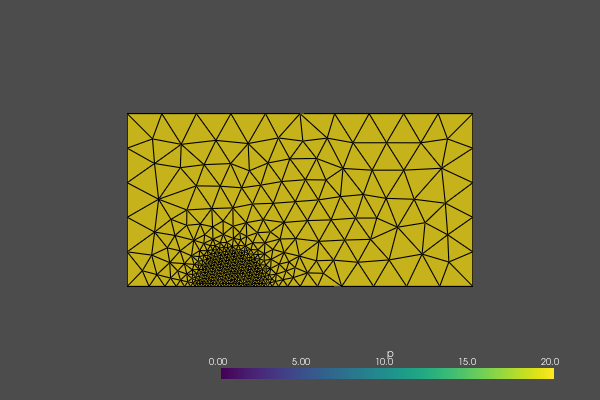

In [17]:
u = fem.Function(V,name="u")
du = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

sig_0 = 1.0
eps_p = fem.Function(V_stress,name="epsp")
p = fem.Function(V_stress_scalar,name="p")
sigma = fem.Function(V_stress,name="stress")

sigma_elas = mu * (eps(u) - eps_p)
deps_p_ = deps_p(sigma_elas, mu, sig_0)
sigma_total = sigma_elas - mu  * deps_p_

residual = ufl.inner(sigma_total, eps(v)) * dx - L(v)
my_problem = SNESSolver(residual, u, bcs=bcs, petsc_options=petsc_options_SNES)


u.vector.set(0)
p.vector.set(0)
eps_p.vector.set(0)

stress_expr = fem.Expression(sigma_total, V_stress.element.interpolation_points())

p_new_expr= fem.Expression(p + ufl.sqrt(ufl.inner(deps_p_,deps_p_)), 
                       V_stress_scalar.element.interpolation_points())

eps_new_expr = fem.Expression(eps_p + deps_p_, 
                         V_stress.element.interpolation_points())

with io.XDMFFile(MPI.COMM_WORLD, "output/plasticity-crack.xdmf", "w") as file:
    file.write_mesh(u.function_space.mesh)
    
for t in np.linspace(0,1.0,50):
    u_t.value = t
    print(f"Solve for t={t}")
    out = my_problem.solve()
    print(out)
    
    sigma.interpolate(stress_expr)
    sigma.x.scatter_forward()
    
    # update
    eps_p.interpolate(eps_new_expr)
    eps_p.x.scatter_forward()
    
    p.interpolate(p_new_expr)
    p.x.scatter_forward()
    

    with io.XDMFFile(MPI.COMM_WORLD, "output/plasticity-crack.xdmf", "a") as file:
        #file.write_mesh(u.function_space.mesh)
        file.write_function(u,t)
        file.write_function(eps_p,t)
        file.write_function(p,t)
        file.write_function(sigmah,t)    
        
import pyvista
pyvista.start_xvfb()

# Create plotter and pyvista grid
topology, cell_types, geometry = plot.create_vtk_mesh(V)
u_grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
u_grid.cell_data["p"] = p.x.array.real
u_grid.set_active_scalars("p")
u_plotter = pyvista.Plotter(window_size=(600, 400))
u_plotter.add_mesh(u_grid, show_edges=True,clim=[0,20])
u_plotter.view_xy()
if not pyvista.OFF_SCREEN:
    u_plotter.show()
    